In [26]:
# Hyperparameter tuning
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
from pathlib import Path
import time
Path("../models").mkdir(parents=True, exist_ok=True)
models_dir = Path("../models")

X_train = joblib.load(models_dir/"X_train.joblib")
X_test  = joblib.load(models_dir / "X_test.joblib")
Y_train = joblib.load(models_dir / "Y_train.joblib")
Y_test  = joblib.load(models_dir / "Y_test.joblib")

In [4]:
param_dist = {
    "n_estimators": [200, 300, 400, 500, 700],
    "max_depth": [8, 12, 16, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.6, 0.8], 
    "bootstrap": [True, False]
}

N_ITER = 25
CV = 3
N_JOBS = -1
VERBOSE = 2
RANDOM_STATE = 42

print("Param search is ready")

Param search is ready


In [5]:
rf_base = RandomForestRegressor(random_state=RANDOM_STATE)

random_search = RandomizedSearchCV(
    estimator = rf_base,
    param_distributions=param_dist,
    n_iter=N_ITER,
    scoring='r2',
    cv=CV,
    n_jobs=N_JOBS,
    verbose=VERBOSE,
    random_state= RANDOM_STATE,
    return_train_score=False
)

In [11]:
t0 = time.time()
random_search.fit(X_train,Y_train)
elapsed = time.time() - t0

print("\nRandomizedSearchCV finished in {:.1f} seconds ({:.1f} minutes)".format(elapsed, elapsed/60.0))
print("Best cross-validated R2 (cv mean):", random_search.best_score_)
print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits

RandomizedSearchCV finished in 32.2 seconds (0.5 minutes)
Best cross-validated R2 (cv mean): 0.5941167245823696
Best parameters: {'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [13]:
# saving the RandomizedSearchCV object and best estimator
joblib.dump(random_search,"../models/rf_random_search.joblib")
joblib.dump(random_search.best_estimator_, "../models/rf_best_estimator.joblib")
print("saving complete")

saving complete


In [16]:
best_est = random_search.best_estimator_
rs = random_search

In [17]:
# testing
Y_pred = best_est.predict(X_test)
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

In [18]:
print("Test R2:", r2)
print("Test MAE:", mae)
print("Test RMSE:", rmse)

Test R2: 0.6266915232168045
Test MAE: 0.25607188006156834
Test RMSE: 0.33978969173166296


In [19]:
# saving
joblib.dump(best_est,"../models/final_rf_turned.joblib")
joblib.dump(list(X_train.columns), "../models/feature_list.joblib")
joblib.dump({"Y_test": Y_test, "preds": Y_pred}, "../models/final_pred_rf_tuned.joblib")
print("Saved final tuned model and artifacts")

Saved final tuned model and artifacts


saved at ../visuals/feature_importances_rf_tuned.png


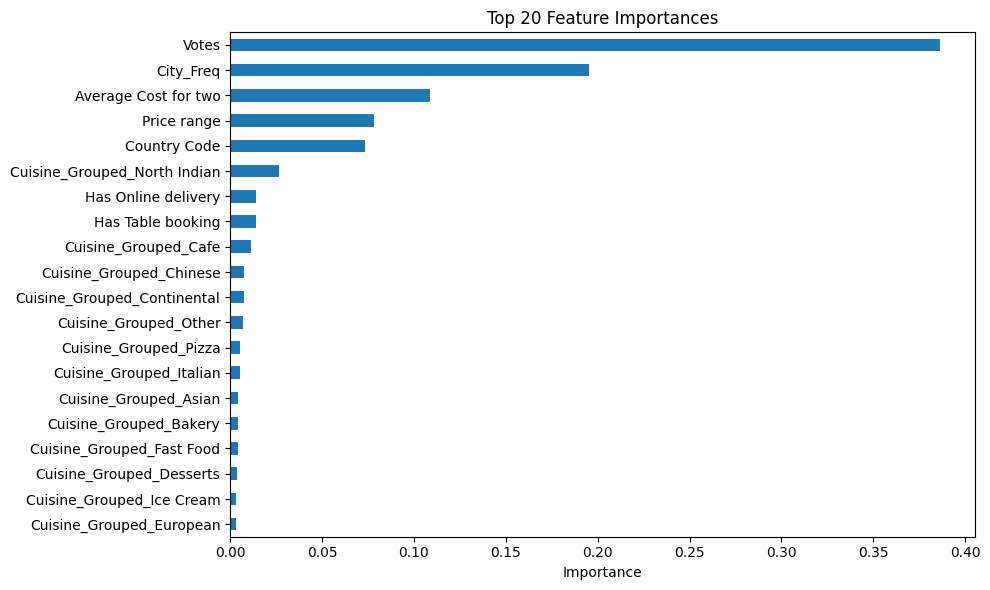

In [23]:
fi = best_est.feature_importances_
feat_names = X_train.columns
imp = pd.Series(fi, index=feat_names).sort_values(ascending=False).head(20)

# Viusal representation
plt.figure(figsize=(10,6))
imp.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()

# saving
out = "../visuals/feature_importances_rf_tuned.png"
plt.savefig(out, dpi=150)
print("saved at",out)

plt.show()

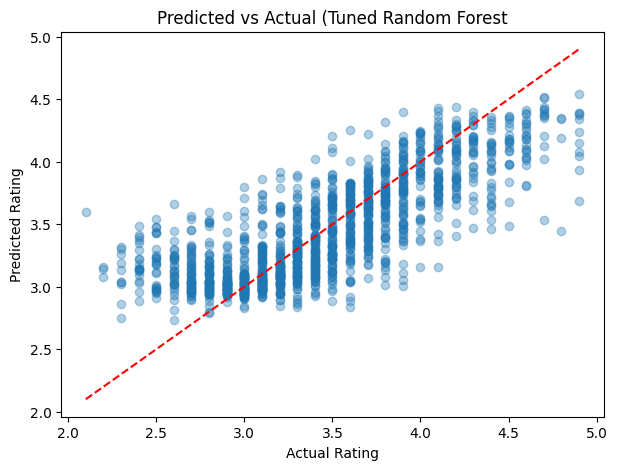

In [25]:
# pred vs Actual
plt.figure(figsize=(7,5))
plt.scatter(Y_test, Y_pred, alpha = 0.35)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Predicted vs Actual (Tuned Random Forest")

#saving
plt.savefig("../visuals/pred_vs_actual_rf_tuned.png", dpi=150)

plt.show()

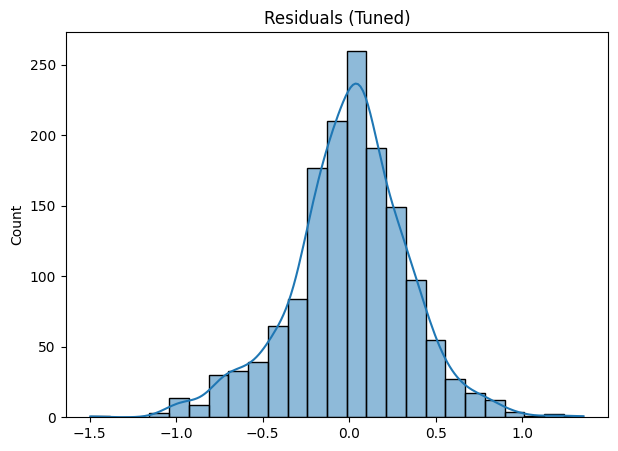

In [27]:
# For residual
res = Y_test.values - Y_pred
plt.figure(figsize=(7,5))
sns.histplot(res,kde=True, bins=25)
plt.title("Residuals (Tuned)")

# saving
plt.savefig("../visuals/residuals_rf_tuned.png", dpi=150)

plt.show()